In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (6,5)
AGENTS = ["B1","B2","B3","B4",
          "C1","C2","C3","C4",
          "D1","D2","D3","D4",
          "E1","E2","E3","E4"]   # any 16-agent ordering you used


In [2]:
path = "ckpt/block_normal/Ours_Attention/44_attn_per_episode.npy"
A = np.load(path)           # shape (E,16,16)
print(f"Loaded {A.shape[0]} episodes   matrix size {A.shape[1:]}")

# quick sanity-check: rows sum to 1 ?
print( np.round(A[0].sum(-1), 3) )     # should all be 1.000


Loaded 10 episodes   matrix size (16, 16)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


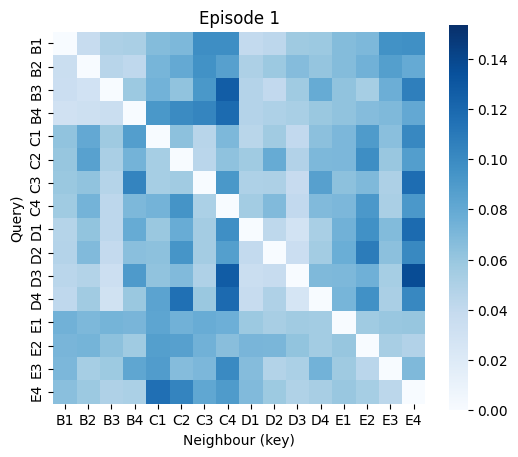

In [3]:
def show_heat(ep=0, cmap="Blues"):
    sns.heatmap(A[ep], vmax=A.max(), vmin=0,
                xticklabels=AGENTS, yticklabels=AGENTS,
                cmap=cmap, square=True, cbar=True)
    plt.title(f"Episode {ep+1}")
    plt.ylabel("Query)"); plt.xlabel("Neighbour (key)")
    plt.show()

show_heat(0)     # first episode


[[0.         0.03753371 0.04940951 0.05339437 0.06775276 0.0720023
  0.09574218 0.10484935 0.03882977 0.04118454 0.05454277 0.0599211
  0.0658191  0.06905224 0.09088169 0.09908464]
 [0.03419083 0.         0.04419465 0.04072741 0.07162663 0.08627892
  0.09285887 0.08671547 0.05153837 0.06174792 0.06646313 0.06187771
  0.06496426 0.077177   0.08267285 0.07696602]
 [0.03258704 0.02859591 0.         0.05704466 0.07385805 0.06405441
  0.08624206 0.1302404  0.04569793 0.03956939 0.05251057 0.07917693
  0.06444165 0.05651676 0.07531579 0.11414851]
 [0.02942021 0.03192274 0.03320839 0.         0.09088384 0.0984035
  0.1026306  0.12173815 0.04589523 0.05007889 0.05166857 0.06101837
  0.06163325 0.06769937 0.07002391 0.08377501]
 [0.06357087 0.0807118  0.05811995 0.09594051 0.         0.06363074
  0.04533794 0.07534595 0.04140029 0.05199936 0.03770209 0.06272126
  0.07081477 0.08680929 0.06232579 0.10356946]
 [0.06239288 0.08977377 0.05216581 0.07521256 0.05361683 0.
  0.04385788 0.06366212 0.05

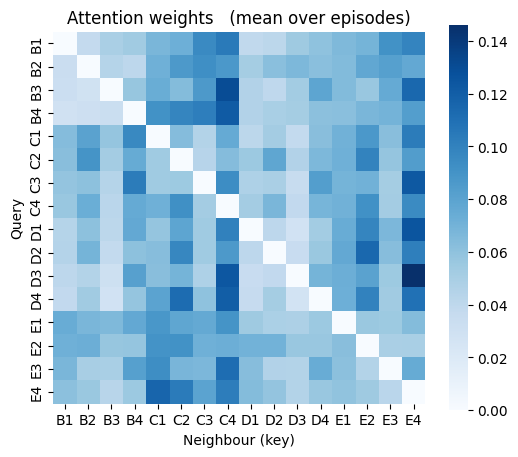

In [4]:
A_mean = A.mean(0)          # (16,16)
print(A_mean)
sns.heatmap(A_mean, vmax=A_mean.max(), vmin=0,
            xticklabels=AGENTS, yticklabels=AGENTS,
            cmap="Blues", square=True)
plt.title("Attention weights   (mean over episodes)")
plt.ylabel("Query"); plt.xlabel("Neighbour (key)")
plt.show()


In [5]:
k = 3
rows = []
for i,recv in enumerate(AGENTS):
    idx = np.argsort(A_mean[i])[::-1][:k]
    rows.append({"Agent":recv,
                 "Top-k": ", ".join([AGENTS[j] for j in idx]),
                 "Weights": ", ".join([f"{A_mean[i,j]:.2f}" for j in idx])})
pd.DataFrame(rows)


,Agent,Top-k,Weights
0,B1,"C4, E4, C3","0.10, 0.10, 0.10"
1,B2,"C3, C4, C2","0.09, 0.09, 0.09"
2,B3,"C4, E4, C3","0.13, 0.11, 0.09"
3,B4,"C4, C3, C2","0.12, 0.10, 0.10"
4,C1,"E4, B4, E2","0.10, 0.10, 0.09"
5,C2,"E2, B2, E4","0.10, 0.09, 0.08"
6,C3,"E4, B4, C4","0.12, 0.10, 0.09"
7,C4,"E4, C2, E2","0.09, 0.09, 0.09"
8,D1,"E4, C4, E2","0.12, 0.10, 0.10"
9,D2,"E2, E4, C2","0.11, 0.10, 0.10"


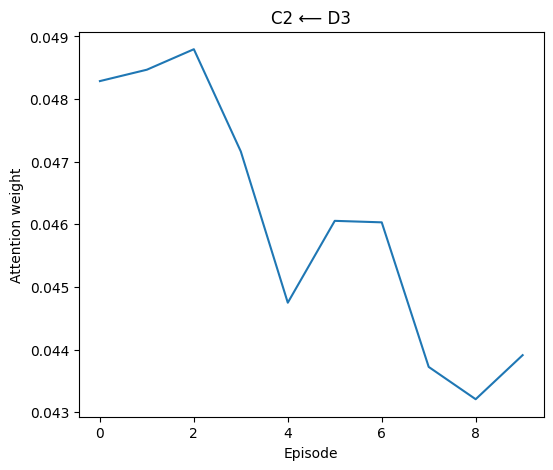

In [6]:
pair = ("C2","D3")        # receiver, neighbour
i, j = AGENTS.index(pair[0]), AGENTS.index(pair[1])

plt.plot(A[:, i, j])
plt.xlabel("Episode"); plt.ylabel("Attention weight")
plt.title(f"{pair[0]} ⟵ {pair[1]}")
plt.show()


In [7]:
def grid_heat(Amean, idx, ax=None, cmap="Blues"):
    """
    Amean : ndarray (16,16)
    idx   : int                
    """

    if ax is None:
        ax = plt.gca()

    # 1-D → 4×4 (column-major) → transpose → flip rows
    mat = Amean[idx].reshape(4, 4).T[::-1]      #   ←★ ONLY 1-LINE CHANGE

    sns.heatmap(mat,
                annot=True, fmt=".02f",
                cmap=cmap, square=True, cbar=False,
                xticklabels=["0","1","2","3"],
                yticklabels=["0","1","2","3"][::-1],
                ax=ax)
    ax.set_title(f"Agent {AGENTS[idx]}")
    ax.set_xlabel("col →")
    ax.set_ylabel("row ↑")



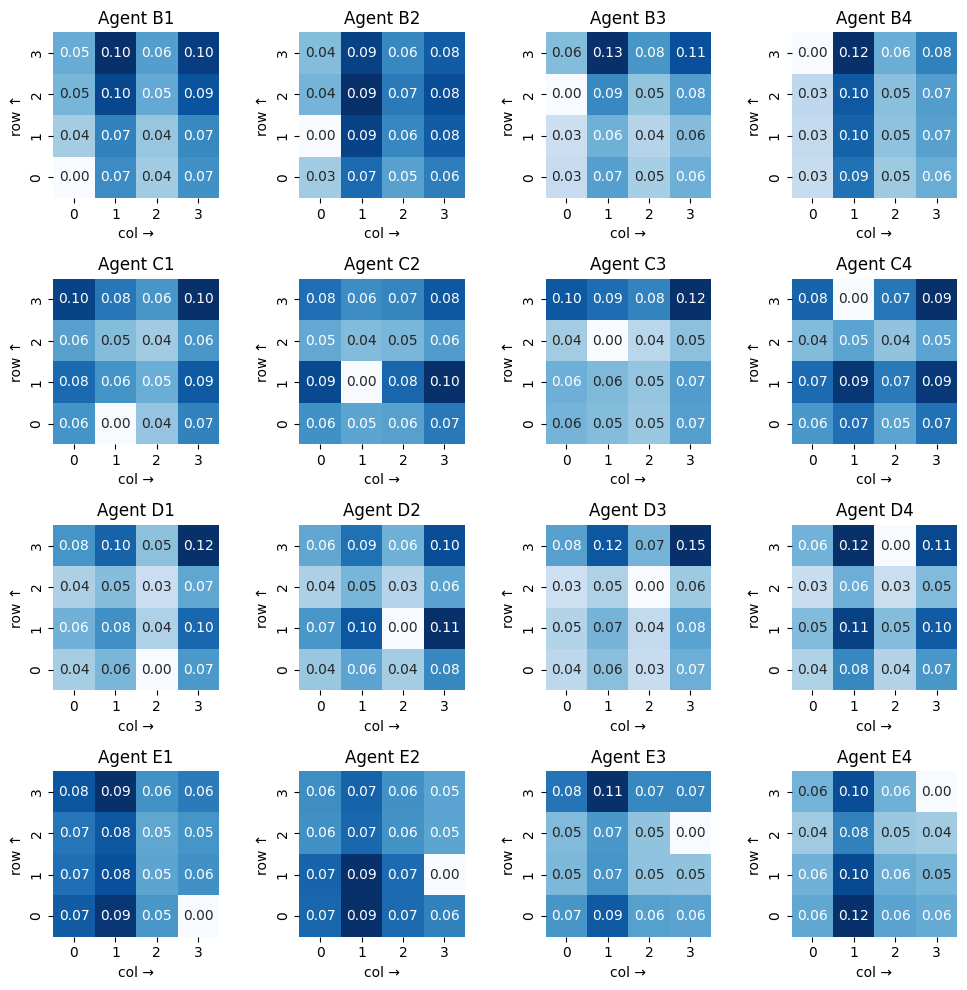

In [8]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
for k,ax in enumerate(axes.ravel()):
    grid_heat(A_mean, k, ax=ax)
plt.tight_layout(); plt.show()
